In [1]:
from multivp_dataset import MULTI_VP_Dataset
from pathlib import Path
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

from sklearn.preprocessing import MinMaxScaler
import numpy as np
from tqdm.notebook import tqdm
import datetime

from models.linear import Generator, Discriminator
from tools.viz import plot_anomaly_scores, plot_train_hist, plot_data_values, plot_anomaly_scores_in_out
from tools.anomaly import madgan_reconstruction, madgan_reconstruction_discr_loss
from tools.logging import Logger

time_id = datetime.datetime.now().strftime("%m%d-%H%M")

class Options:
    def __init__(self):
        # Dataset
        self.data_path = Path('../data/compiled/inputs.csv')
        self.batch_size = 128
        self.nworkers = 4
        self.shuffle = True
        self.method = "joint"
        self.scaler = MinMaxScaler((0, 1))
        self.l_dim = 128
        self.remove_extreme = True
        # self.wsize = 5
        
        # Train params
        self.G_lr = 0.0001
        self.D_lr = 0.0002
        self.epochs = 300
        self.sample_interval = self.epochs // 2
        self.train_plots = True
        # self.D_niters = 10
        # self.G_niters = 5
        
        # create ouput dirs
        self.model_out = Path('./runs/linear/' + time_id)
        if not self.model_out.exists(): self.model_out.mkdir(parents=True)
        (self.model_out / "img").mkdir(exist_ok=True)
        
        # logging
        self.tags = ["linear", "joint", "minmax", "test"]
        self.desc = "Stacked Linear final (tanh)"
        self.type = "Linear"
        
        
opts = Options()


# Setup Training Dataset

In [2]:
dataset = MULTI_VP_Dataset(
    path=opts.data_path,
    method=opts.method,
    remove_extreme=opts.remove_extreme,
    is_train=True,
    scaler=opts.scaler,
    # window_size=opts.wsize,
    # use_pca=True,
    # pca_scaler=StandardScaler(),
    # n_components=128   
)
dataloader = DataLoader(dataset, batch_size=opts.batch_size, shuffle=True, num_workers=opts.nworkers, drop_last=False)

Excluding 1179 val files
Removed 631 extreme values
Inputs shape: (9962, 1280)
Inputs head:
 [[0.25825445 0.25848101 0.25870853 ... 0.         0.         0.        ]
 [0.26357888 0.2638036  0.26402926 ... 0.         0.         0.        ]
 [0.27695434 0.27718189 0.27741038 ... 0.         0.         0.        ]
 [0.25461553 0.25483148 0.25504835 ... 0.         0.         0.        ]
 [0.27191478 0.27212993 0.27234597 ... 0.         0.         0.        ]]


In [3]:
# dataset.plot(title="Magnetic Field")

# Models

In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Using device: ", device)

netG = Generator(
    input_size=dataset.inputs.shape[1],
    hidden_size=640,
    output_size=dataset.inputs.shape[1],
    nlower=2,
    neg_slope=0.2
).to(device)

netD = Discriminator(
    input_size=dataset.inputs.shape[1],
    hidden_size=640,
    nlayers=1, 
    neg_slope=0.2
).to(device)

Using device:  cuda:0


In [5]:
netG.train()

Generator(
  (main): Sequential(
    (inl): Linear(in_features=1280, out_features=640, bias=True)
    (inleaky): LeakyReLU(negative_slope=0.2, inplace=True)
    (linl1): Linear(in_features=640, out_features=640, bias=True)
    (linleaky1): LeakyReLU(negative_slope=0.2, inplace=True)
    (linl2): Linear(in_features=640, out_features=640, bias=True)
    (linleaky2): LeakyReLU(negative_slope=0.2, inplace=True)
    (out): Linear(in_features=640, out_features=1280, bias=True)
  )
)

In [6]:
netD.train()

Discriminator(
  (main): Sequential(
    (in): Linear(in_features=1280, out_features=640, bias=True)
    (in_leaky): LeakyReLU(negative_slope=0.2, inplace=True)
    (l1): Linear(in_features=640, out_features=320, bias=True)
    (leaky1): LeakyReLU(negative_slope=0.2, inplace=True)
    (out): Linear(in_features=320, out_features=1, bias=True)
    (sigmoid): Sigmoid()
  )
)

In [7]:
logger = Logger([netG, netD], opts.model_out / f"{time_id}.md", vars(opts))

runs/linear/0530-1653


# Training

In [8]:
# Initialize BCELoss function
criterion = nn.BCELoss()

# Establish convention for real and fake labels during training
real_label = 1
fake_label = 0

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=opts.D_lr)
optimizerG = optim.Adam(netG.parameters(), lr=opts.G_lr)

In [9]:
# Training Loop

# Lists to keep track of progress
G_losses = []
D_losses = []
iters = 0
best_loss = np.inf
best_loss_dist = np.inf

print("Starting Training Loop...")
# For each epoch
for epoch in range(opts.epochs):
    D_epoch_loss = 0
    G_epoch_loss = 0
    
    # For each batch in the dataloader
    for i, (x, _filename) in enumerate(dataloader): # tqdm(enumerate(dataloader), desc=f"Epoch [{epoch}/{opts.epochs}]", total=len(dataloader), leave=False):
        
        # Format batch
        real = x.to(device)
        b_size, seq_len = real.size(0), real.size(1)
        real_labels = torch.full((b_size, 1), real_label, dtype=torch.float, device=device)
        
        # Train discriminator network to maximize log(D(x)) + log(1 - D(G(z)))
        # for _ in range(opts.D_niters):
        netD.zero_grad()
        
        # Train with real batch
        output = netD(real)
        errD_real = criterion(output, real_labels)
        errD_real.backward()
        
        # Train with fake batch
        fake = netG(torch.randn_like(real, device=device))
        fake_labels = torch.full((b_size, 1), fake_label, dtype=torch.float, device=device)
        
        output = netD(fake.detach())
        errD_fake = criterion(output, fake_labels)
        errD_fake.backward()
        
        errD = errD_real + errD_fake
        optimizerD.step()
        D_losses.append(errD.item())
        
        # Train generator network to maximize log(D(G(z)))
        # for _ in range(opts.G_niters):
        netG.zero_grad()
        
        fake = netG(torch.randn_like(real, device=device))
        output = netD(fake)
        errG = criterion(output, real_labels)
        errG.backward()
        optimizerG.step()
        G_losses.append(errG.item())
        # send losses to tensorboard
        iters += 1
        
    # Calculate epoch losses
    output = netD(real)
    errD_real = criterion(output, real_labels)
    D_x = output.mean().item()
    
    fake = netG(torch.randn_like(real, device=device)).detach()
    output = netD(fake)
    errD_fake = criterion(output, fake_labels)
    D_G_z1 = output.mean().item()
    
    errD = errD_real + errD_fake
    errG = criterion(output, real_labels)

    # Output training stats
    print('[%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f'
            % (epoch, opts.epochs,
                errD.item(), errG.item(), D_x, D_G_z1), end="\r", flush=True)

    # save best model if total loss is better than last 
    # and distance between losses is better than last (model convergence)
    if abs(errD-errG).item() < best_loss_dist and epoch > 2: 
        best_loss_dist = torch.abs(errD-errG).item()
        torch.save(netG.state_dict(), opts.model_out / 'Gbest.pth')
        torch.save(netD.state_dict(), opts.model_out / 'Dbest.pth')
        
        if opts.train_plots:
            fake = dataset.unscale(fake.detach().cpu().numpy())
            # fake = dataset.flatten(fake.detach().cpu().numpy())
            fig = plot_data_values(fake, 
                            title=f"Epoch {epoch} - G loss: {errG.item():.4f} - D loss: {errD.item():.4f}", 
                            labels=["B [G]", "alpha [deg]"],
                            scale="linear")
            fig.savefig(opts.model_out / f"img/{epoch}_best", dpi=200)
            plt.close(fig)
    elif epoch % opts.sample_interval == 0:
        torch.save(netG.state_dict(), opts.model_out / f'G{epoch}.pth')
        torch.save(netD.state_dict(), opts.model_out / f'D{epoch}.pth')
        
        if opts.train_plots:
            # fake = dataset.flatten(fake.detach().cpu().numpy())
            fake = dataset.unscale(fake.detach().cpu().numpy())
            fig = plot_data_values(fake, 
                            title=f"Epoch {epoch} - G loss: {errG.item():.4f} - D loss: {errD.item():.4f}", 
                            labels=["B [G]", "alpha [deg]"],
                            scale="linear")
            fig.savefig(opts.model_out / f'img/inter_{epoch}.png', dpi=200)
            plt.close(fig)
            
        train_f = plot_train_hist(D_losses, G_losses, opts.model_out)
        plt.close(train_f)
    

Starting Training Loop...


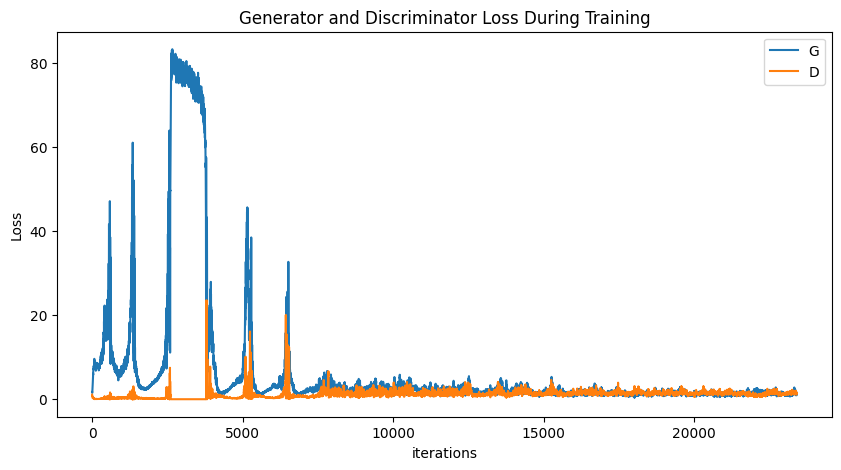

In [10]:
fig = plot_train_hist(D_losses, G_losses, opts.model_out)

# Anomaly Detection

In [11]:
netD.eval()
netG.eval()

class AnomalyParams:
    batch_size = 128
    models_dir = opts.model_out
    # models_dir = Path("./runs/linear/0525-1009")
    # reconstruction based
    niter = 150 # number of iterations for reconstruction
    lambda_thresh = 0.1
    lr = 1e-2
    data_compiled = opts.data_path
    
opts_eval = AnomalyParams()

# load best models
netG.load_state_dict(torch.load(opts_eval.models_dir / 'Gbest.pth'))
netD.load_state_dict(torch.load(opts_eval.models_dir / 'Dbest.pth'))

<All keys matched successfully>

In [12]:
eval_dataset = MULTI_VP_Dataset._from(dataset)
# eval_dataset = MULTI_VP_Dataset(opts.data_path, method=opts.method, scaler=opts.scaler, window_size=10, pca=True, n_components=opts.n_components)
eval_dataloader = DataLoader(eval_dataset, batch_size=opts_eval.batch_size, shuffle=False, num_workers=opts.nworkers)

Inputs shape: (11771, 1280)
Inputs head:
 [[0.25825445 0.25848101 0.25870853 ... 0.         0.         0.        ]
 [0.26357888 0.2638036  0.26402926 ... 0.         0.         0.        ]
 [0.27695434 0.27718189 0.27741038 ... 0.         0.         0.        ]
 [0.25461553 0.25483148 0.25504835 ... 0.         0.         0.        ]
 [0.27191478 0.27212993 0.27234597 ... 0.         0.         0.        ]]


## Discriminator Classification

In [13]:
scores = []
# calculate classification scores for each sample
for i , (x, filenames) in enumerate(eval_dataloader):
    outputs = netD(x.to(device))
    # calculate mean classification score for each sample
    for sample, filename in zip(outputs, filenames):
        # print(sample, filename)
        class_avg = sample[0]
        scores.append((filename, 1-class_avg.item()))

Anomaly Threshold:  0.455522358417511
Found 1177 anomalies


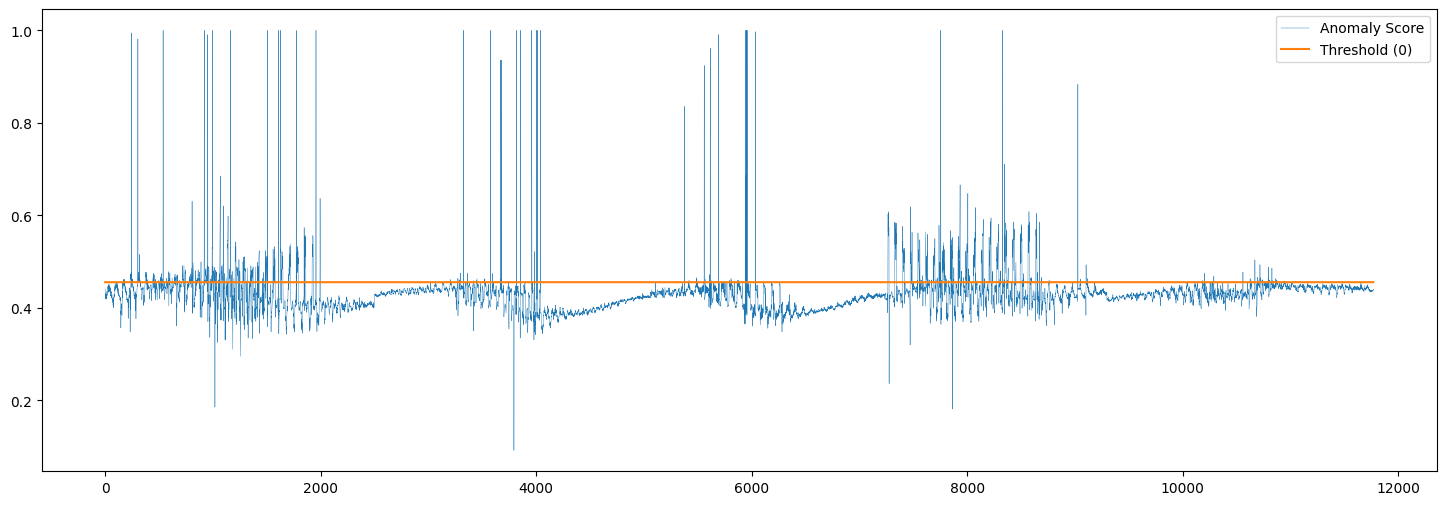

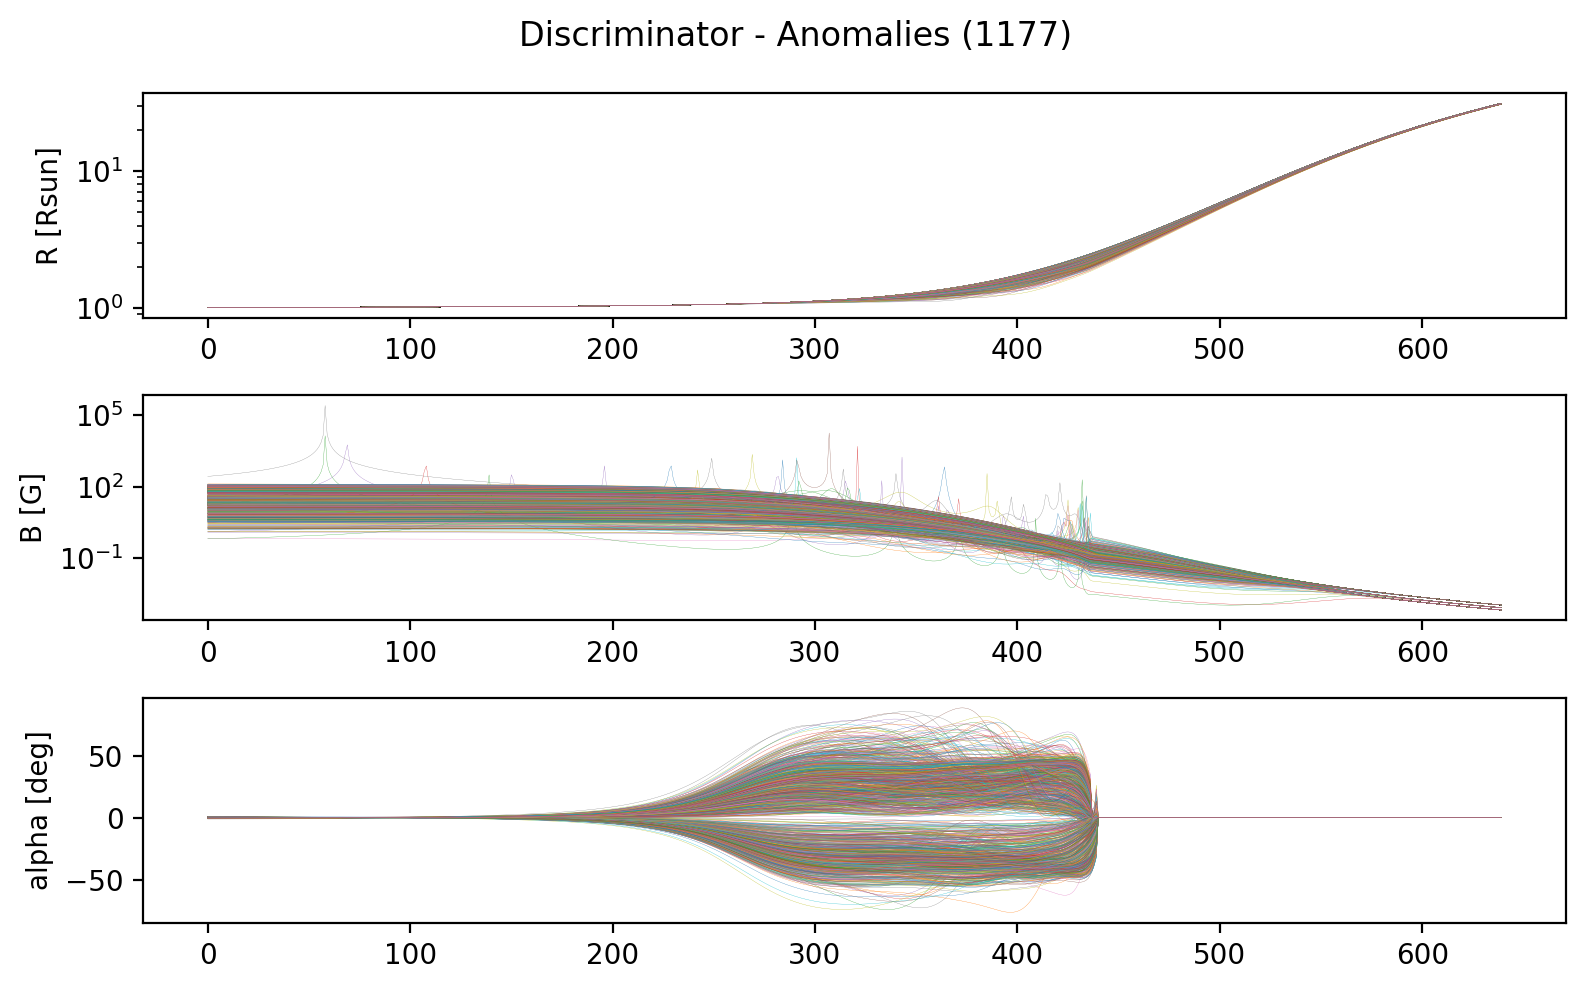

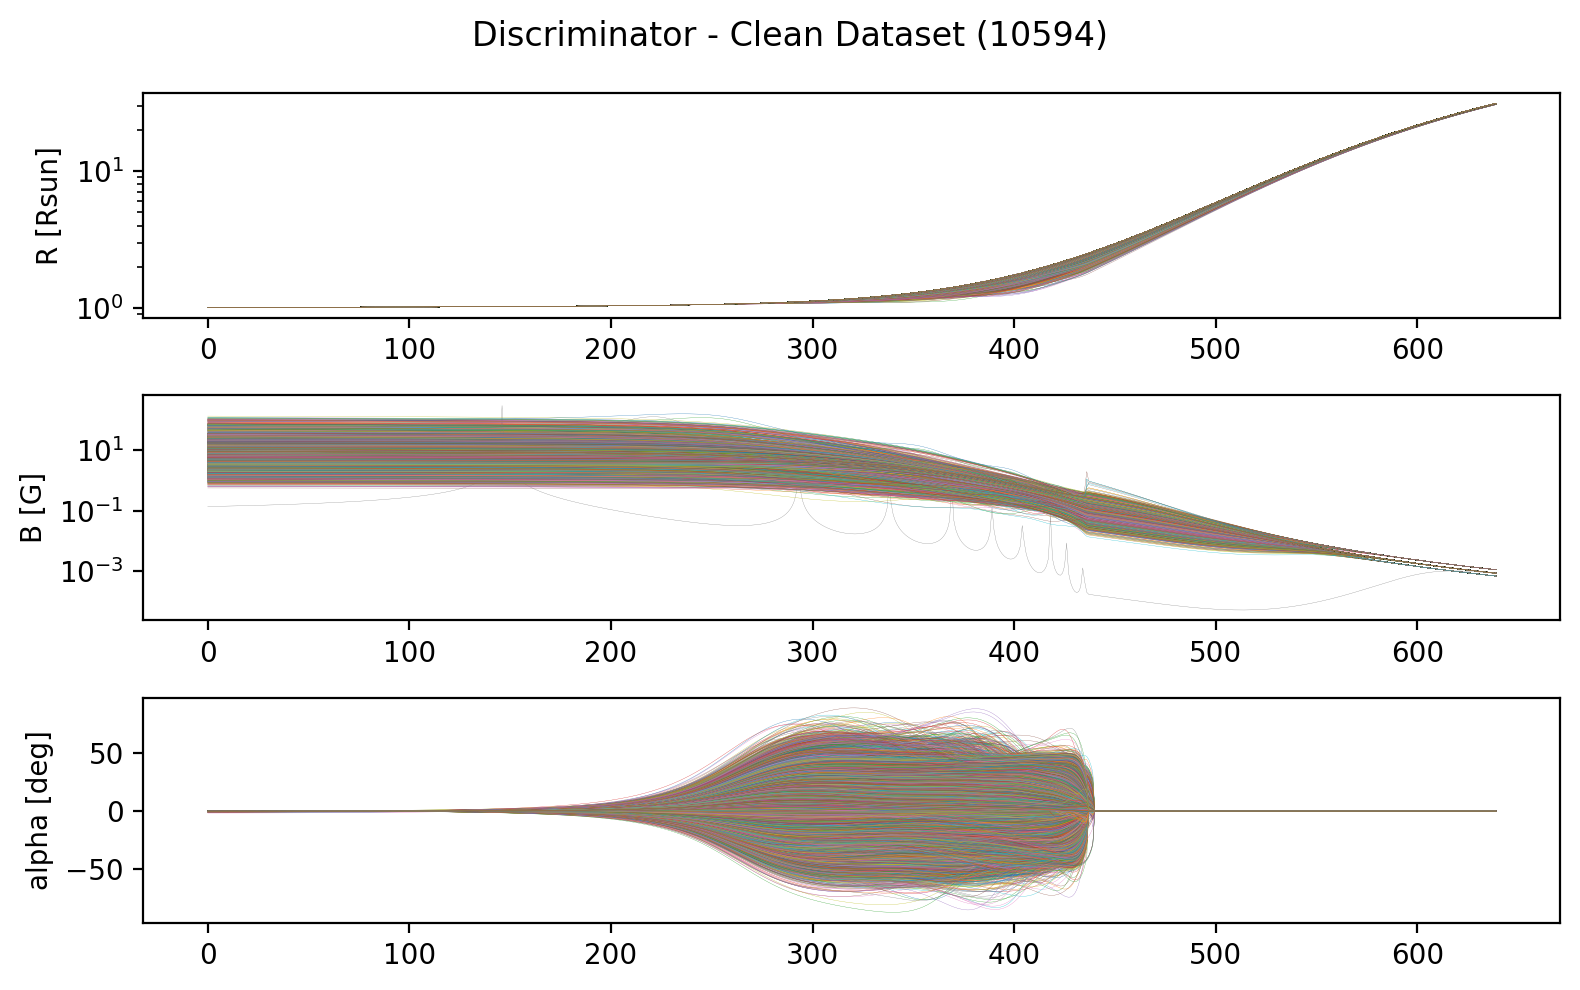

In [14]:
anomalies =\
    plot_anomaly_scores(scores, 0.1, opts_eval.data_compiled, opts_eval.models_dir /  f"img/discr_scores",
                        scale="linear", method="Discriminator", normal_plot=True)

## Reconstruction Based

In [15]:
def reconstruction_anomaly_scores(dataloader, netG : nn.Module, netD : nn.Module, device : str,
                                  max_iters=100, reconstr_fn=madgan_reconstruction):
    mse_scores = []
    for i, (x, filenames) in enumerate(dataloader, 0):
        _z, loss = reconstr_fn(x, netG, netD, device, max_iters)
        # print(loss.shape)
        mse_scores.extend(zip(filenames, [l.mean().detach().cpu().numpy() for l in loss]))
        print(f"[{i}/{len(dataloader)}]", end='\r', flush=True)
        
    return mse_scores

### MSE Reconstruction

In [16]:
reconstr_scores = reconstruction_anomaly_scores(eval_dataloader, netG, netD, device, opts_eval.niter, madgan_reconstruction)

Anomaly Threshold:  0.046827193
Found 1177 anomalies


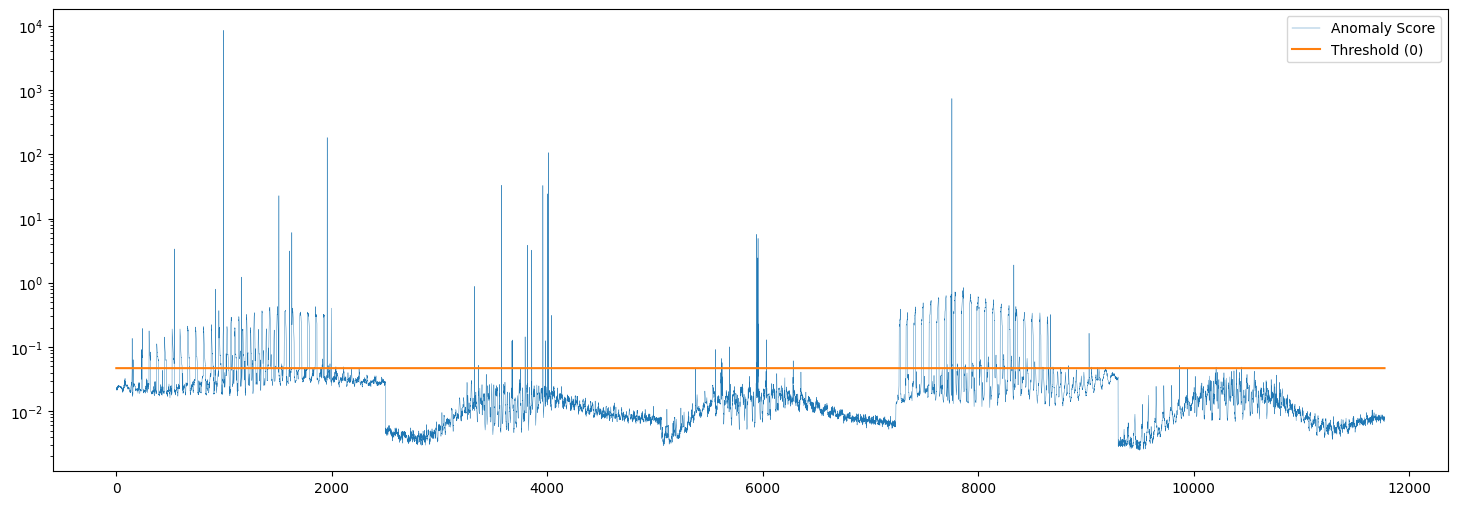

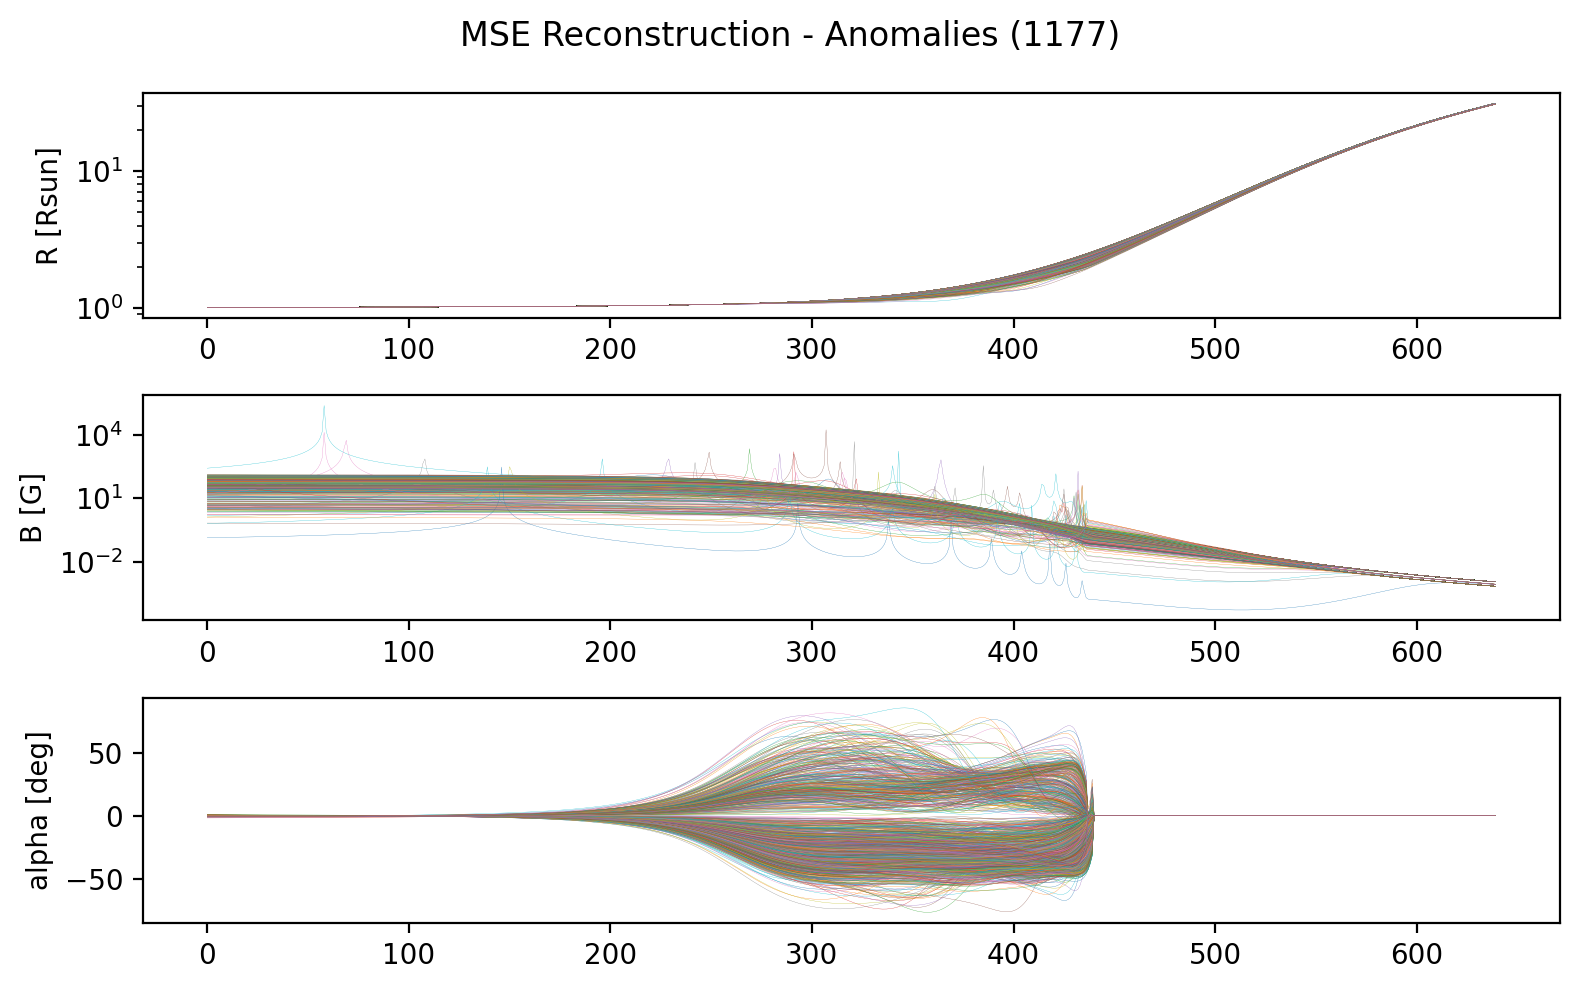

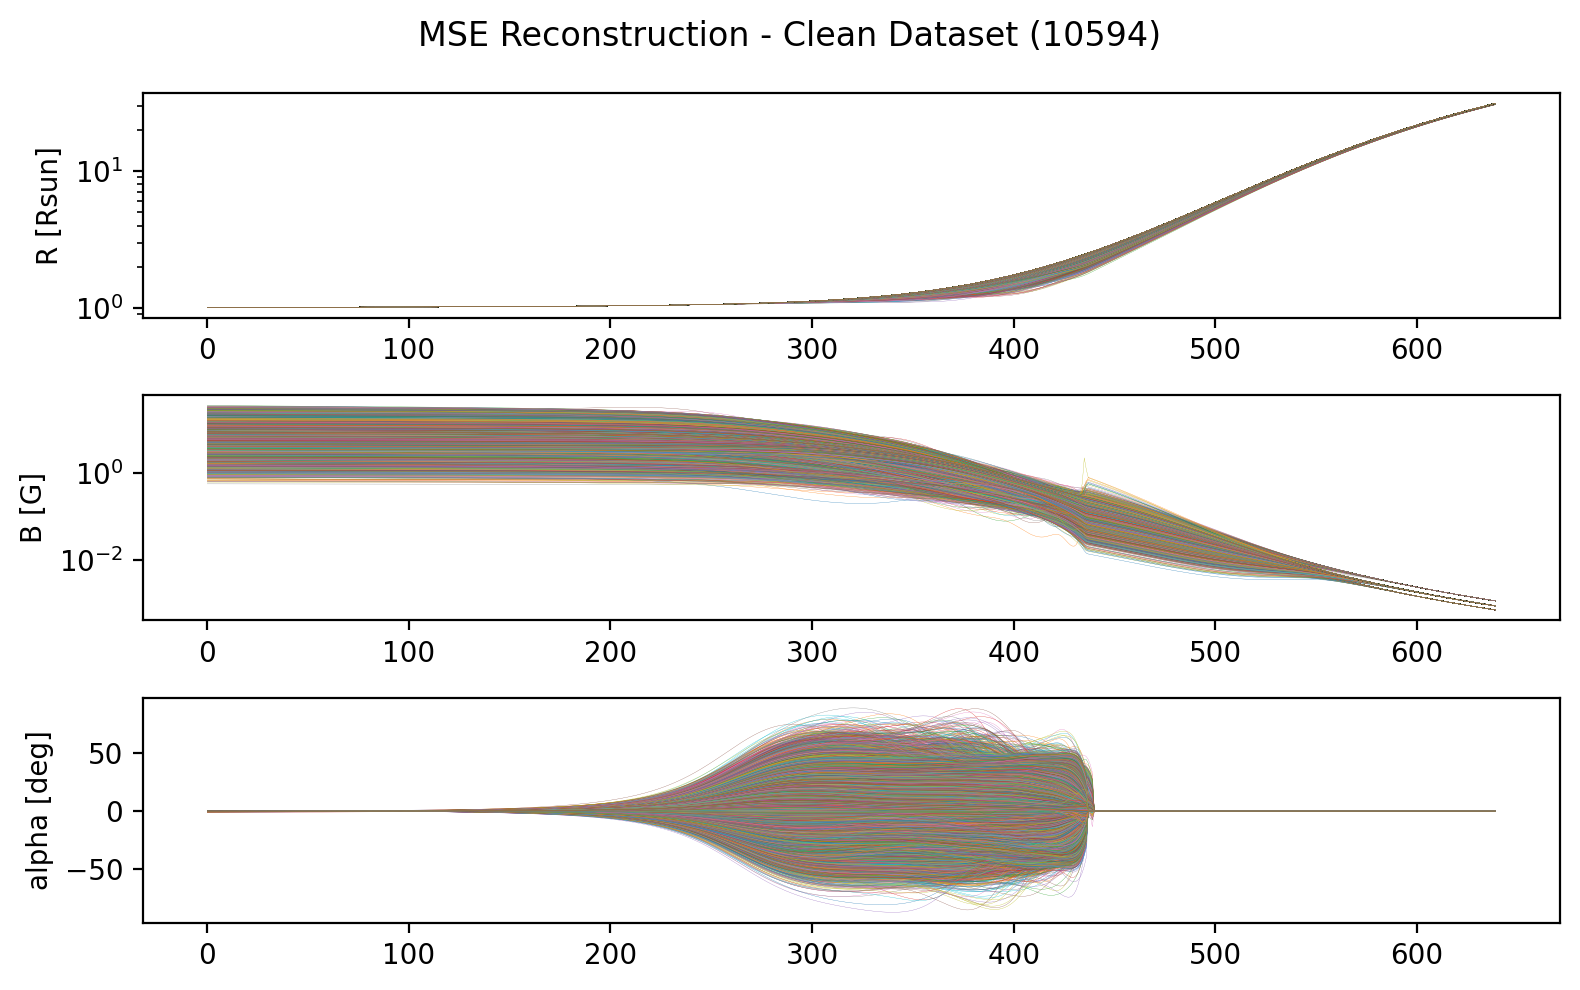

In [17]:
anomalies =\
    plot_anomaly_scores(reconstr_scores, 0.1, opts_eval.data_compiled, opts_eval.models_dir /  f"img/mse", 
                        scale="log", method="MSE Reconstruction", normal_plot=True)

### MSE Reconstruction with Discriminator feedback

In [18]:
reconstr_scores_discr = reconstruction_anomaly_scores(eval_dataloader, netG, netD, device,
                                                      opts_eval.niter, madgan_reconstruction_discr_loss)

Anomaly Threshold:  5.7380744e-06
Found 1177 anomalies


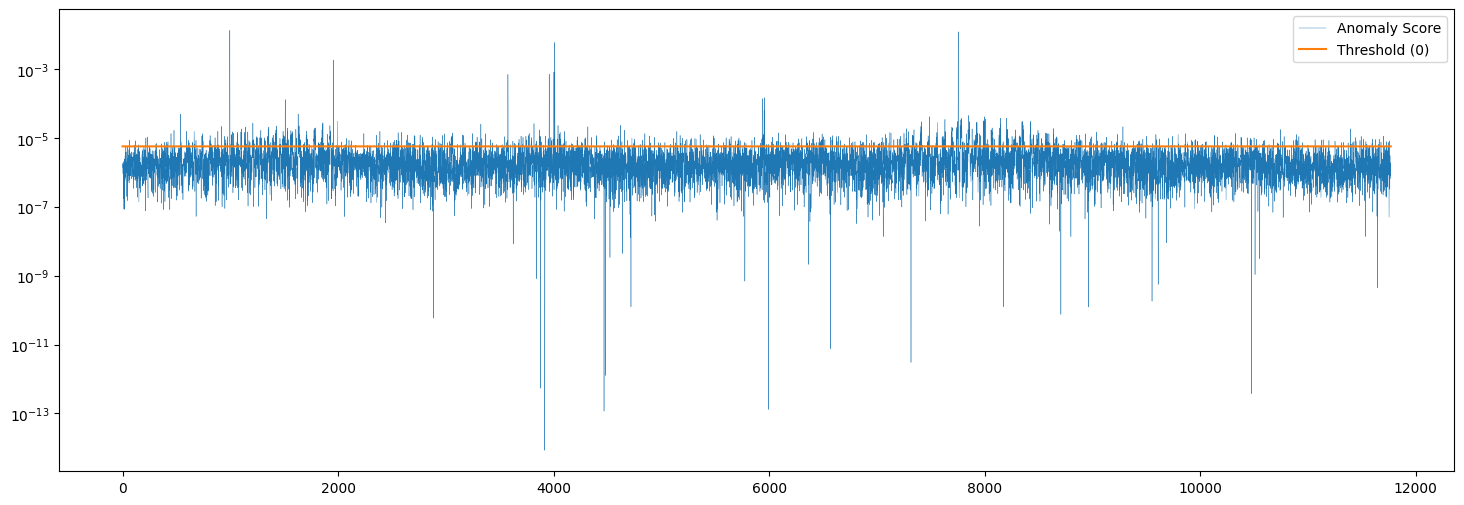

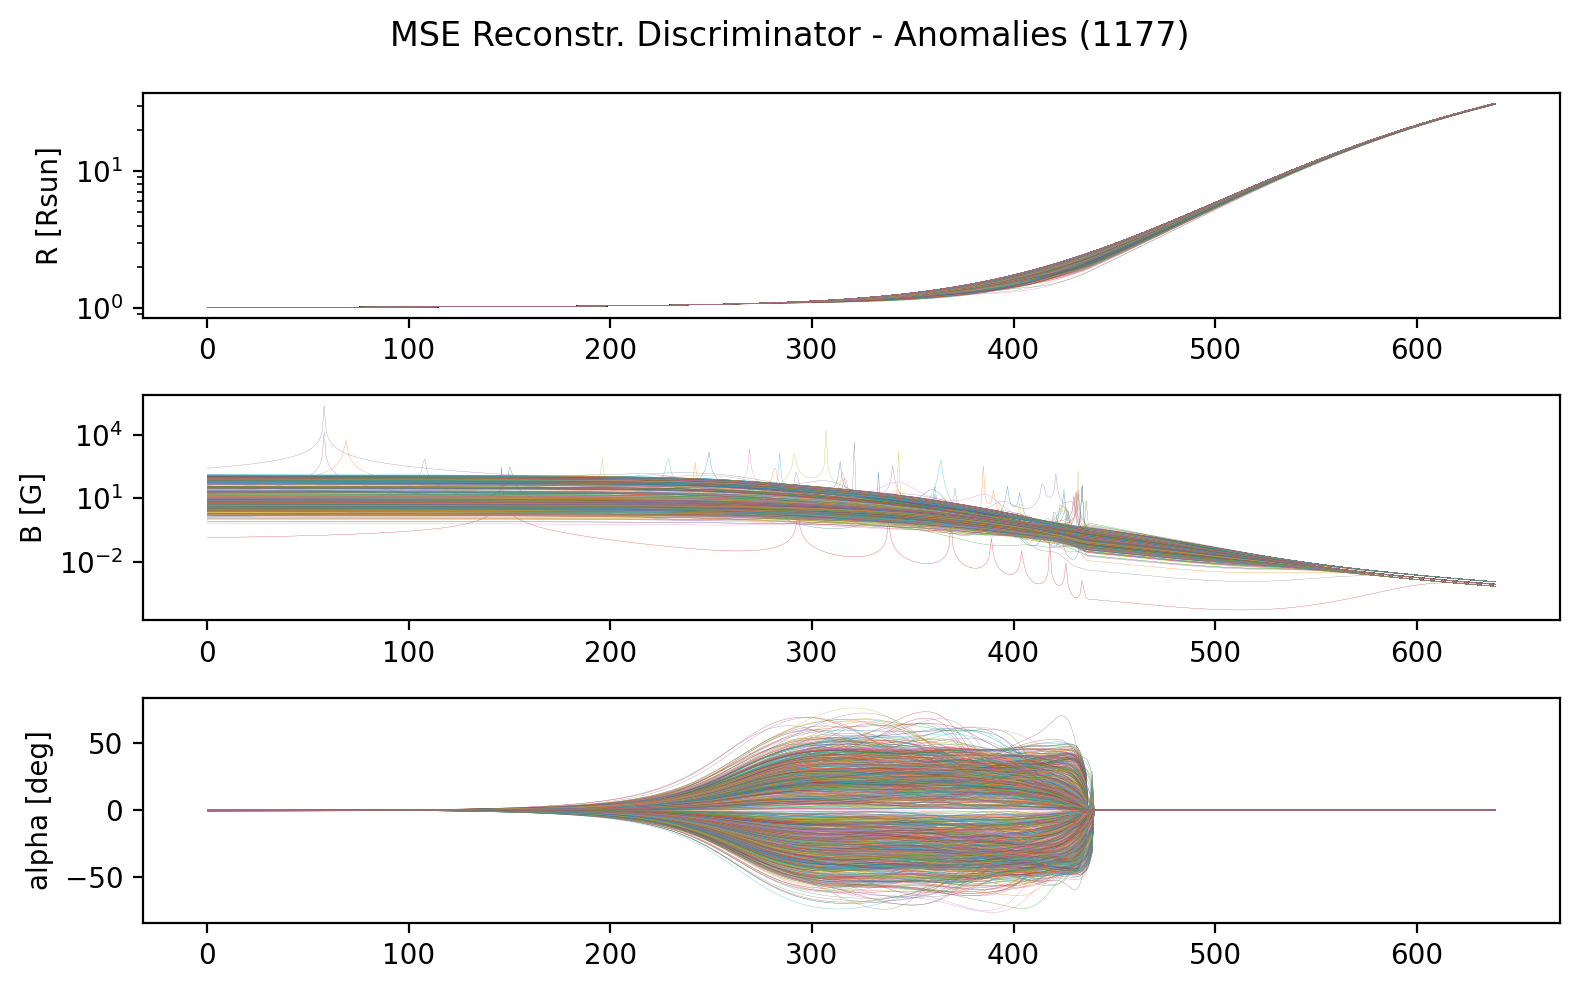

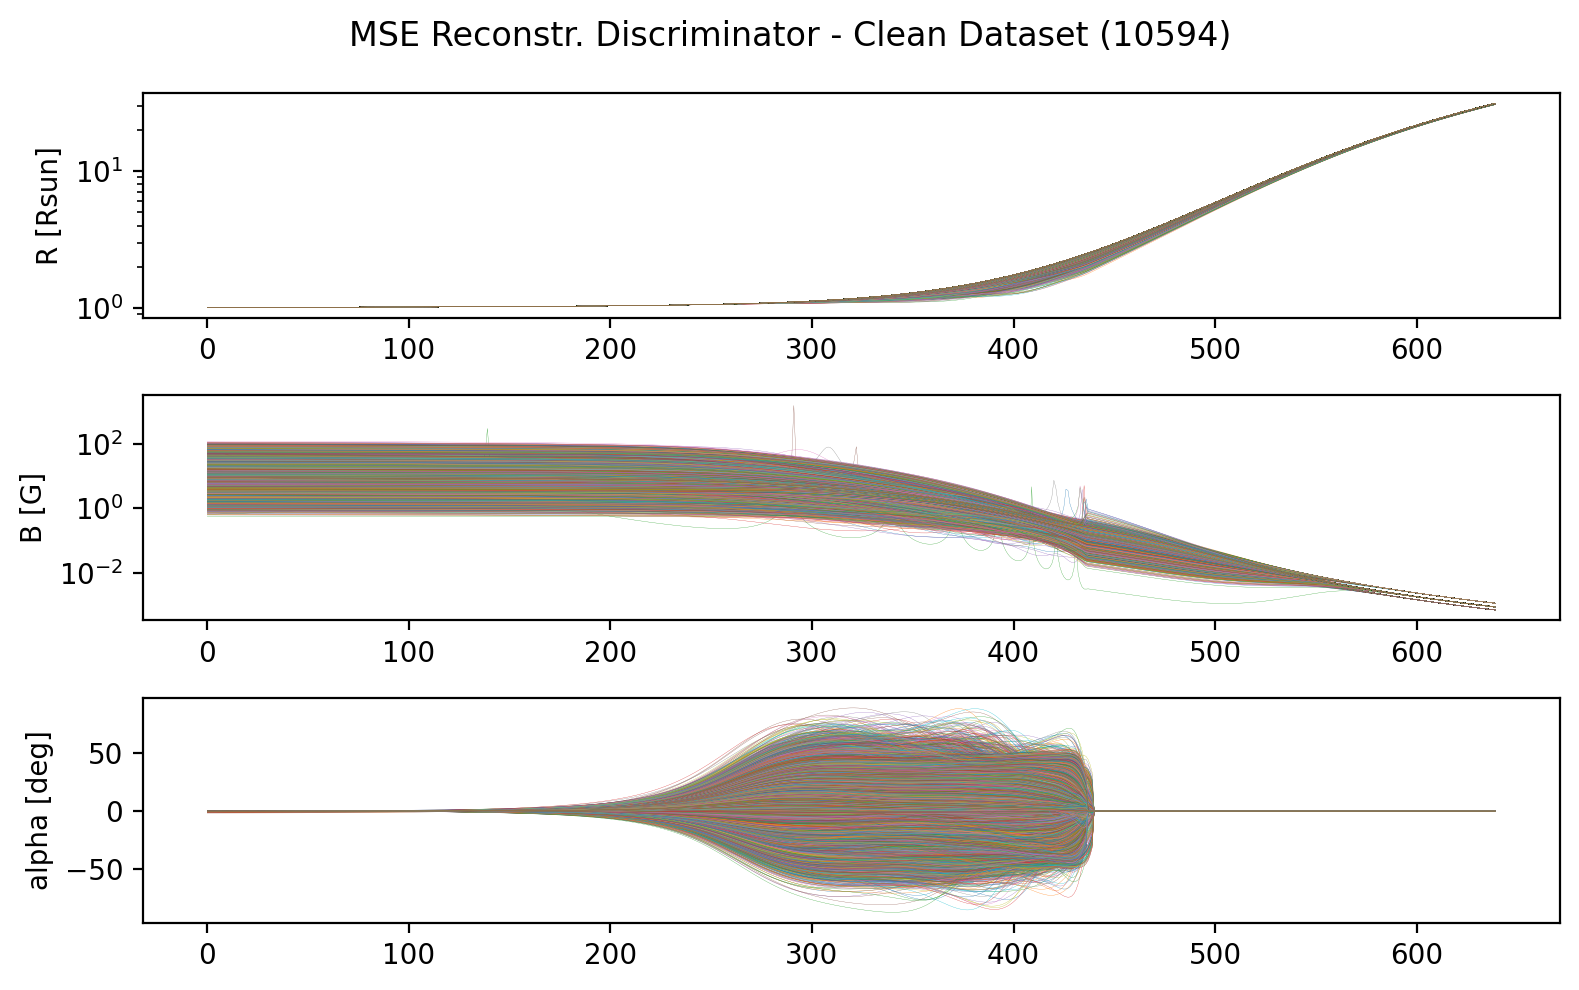

In [19]:
anomalies =\
    plot_anomaly_scores(reconstr_scores_discr, 0.1, opts_eval.data_compiled, opts_eval.models_dir /  f"img/mse_discr",
                        scale="log", method="MSE Reconstr. Discriminator", normal_plot=True)

### Feature Reconstruction

In [20]:
reconstr_feature_scores = reconstruction_anomaly_scores(eval_dataloader, netG, netD, device,
                                                        opts_eval.niter, madgan_reconstruction_discr_loss)

Anomaly Threshold:  5.687271e-06
Found 1177 anomalies


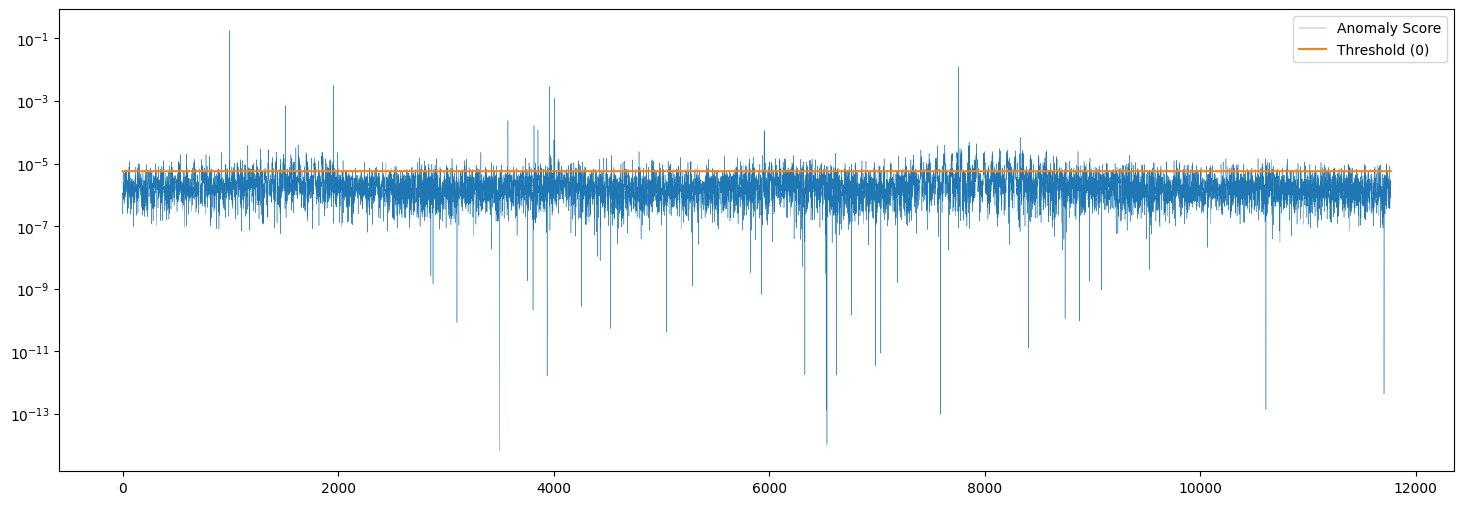

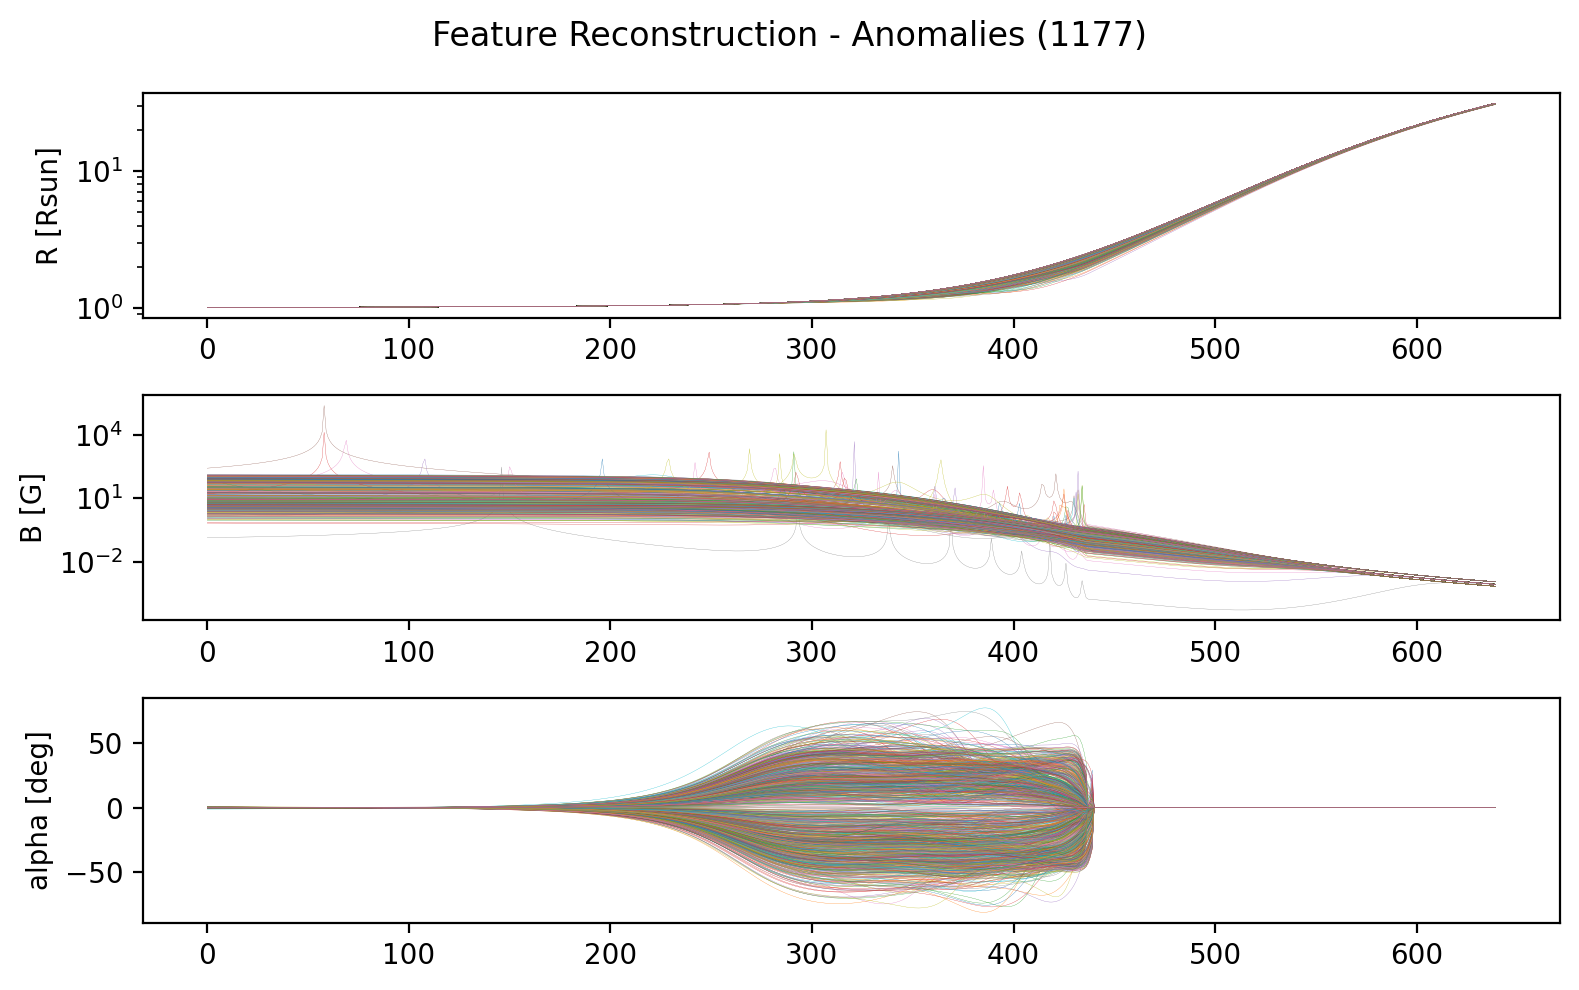

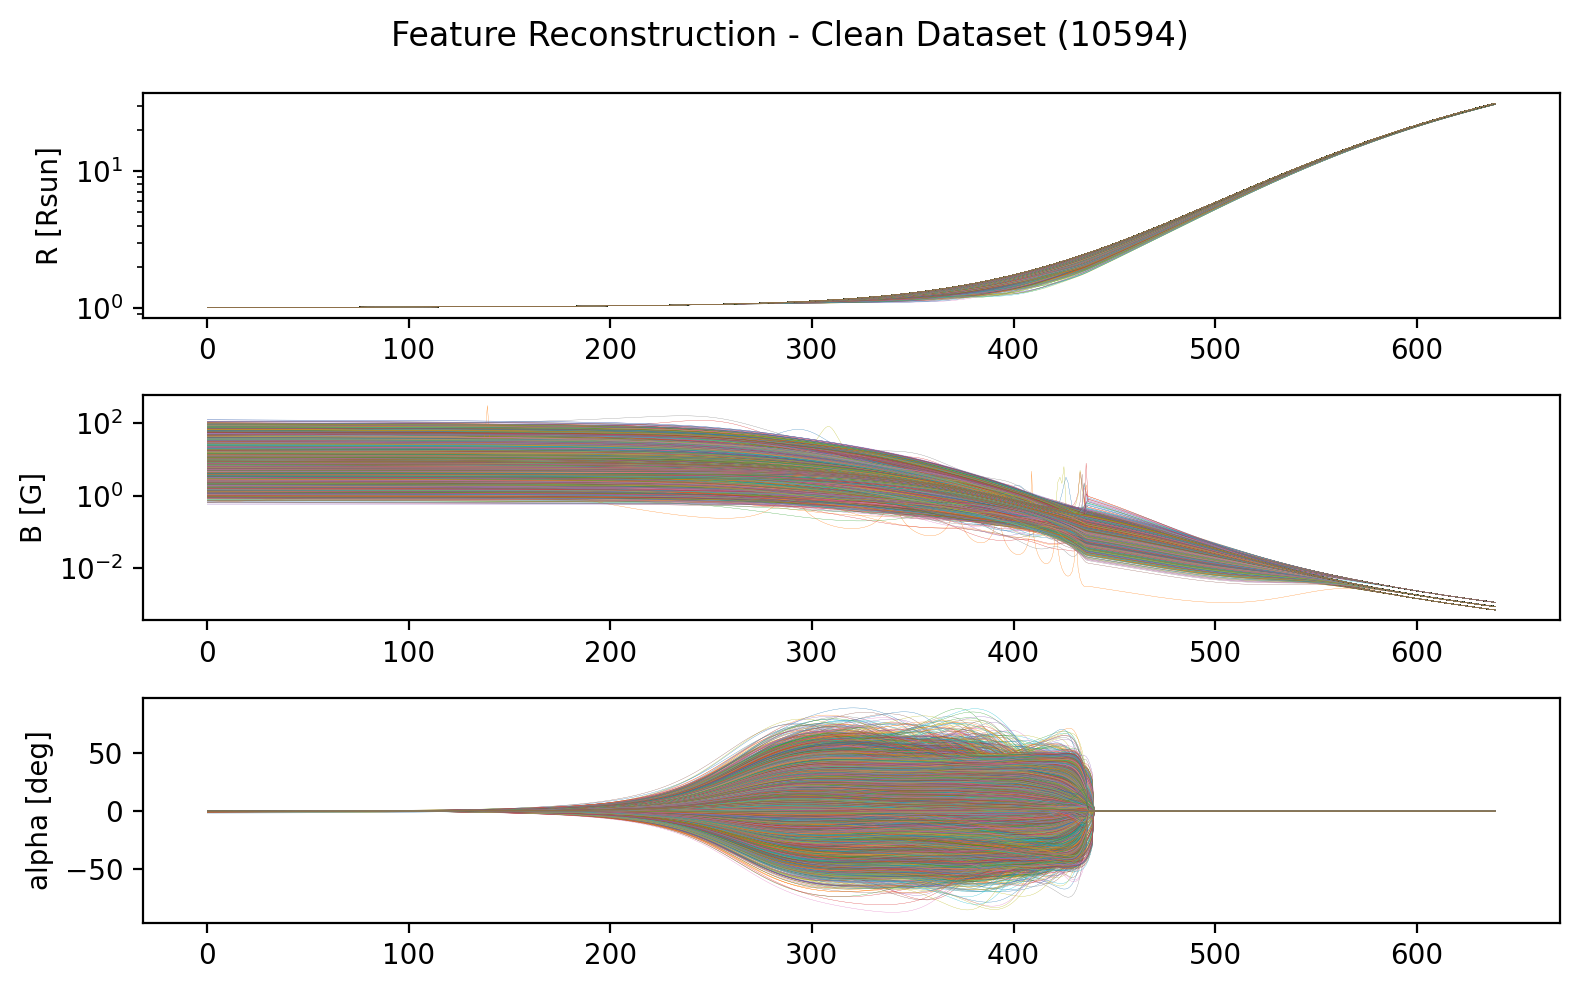

In [21]:
anomal_fig =\
    plot_anomaly_scores(reconstr_feature_scores, 0.1, opts_eval.data_compiled, opts_eval.models_dir /  f"img/mse_feature",
                        scale="log", method="Feature Reconstruction", normal_plot=True)